**Capstone Project Group A CV1**

## Pneumonia Detection Challenge
The goal is to build a pneumonia detection system, to locate the position of inflammation in an image.

This model is built using Detectron2 (Faster_RCNN) on pytorch: https://github.com/facebookresearch/detectron2


**Data preprocessing steps needed are as below:**
1. Convert all the dicom images to jpg as Detectron2 can't directly read dicom images  : *convert_to_jpg()*
2. Image augmentation using albumentations library
3. Convert the data to coco json format : *get_data_dicts()*

In [1]:
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
!pip install pydicom
!pip install sklearn
!pip install funcy
!pip install argparse
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 274 kB 4.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=f245e78467b3223b8d1b24f55c65c70e5fa181f7f24adc71e8d63665e23fe82d
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
     |████████████████████████████████| 6.9 MB 733 kB/s 
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 145 kB 11.7 MB/s 
     |████████████████████████████████| 130 kB 58.7 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 743 kB 55.3 MB/s 
     |████████████████████████████████| 749 kB 50.4 MB/s 
     |██

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.6 MB 65 kB/s 
albumentations==1.1.0 is successfully installed


In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu111 True


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import glob, os, json, cv2, random
from google.colab.patches import cv2_imshow
import pydicom as pyd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

In [4]:
base_dir='/content/drive/MyDrive/colab'
data_dir = base_dir+'/input'

train_labels_df = pd.read_csv(data_dir+'/stage_2_train_labels.csv')
label_meta_data = pd.read_csv(data_dir+'/stage_2_detailed_class_info.csv')

train_dicom_dir = os.path.join(data_dir, 'stage_2_train_images')
test_dicom_dir = os.path.join(data_dir, 'stage_2_test_images')

train_labels_df.tail(10)

,patientId,x,y,width,height,Target
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1
30226,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1


In [6]:
def get_files(dicom_dir):
    files = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(files))

def parse_dataset(dicom_dir, anns): 
    image_files = get_files(dicom_dir)
    image_annotations = {fp: [] for fp in image_files}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
        if index == 0:
          print(row)
    return image_files, image_annotations 

image_files, image_annotations = parse_dataset(train_dicom_dir, anns=train_labels_df)

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [7]:
import albumentations as A
from  albumentations.core.composition import BboxParams
transform = A.Compose([
              A.RandomCrop(width=1024, height=1024),
              A.HorizontalFlip(p=0.5),
              A.RandomBrightnessContrast(p=0.2),
          ],  bbox_params=BboxParams(format='coco', min_area=1024, min_visibility=0.1)
)

In [8]:
def convert_to_jpg(input_file, output_file):
    ds = pyd.dcmread(input_file)
    cv2.imwrite(output_file, ds.pixel_array)

def show(d):  
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pnuemonia_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# for d in ["test"]:
#     input_path = os.path.join(data_dir, "stage_2_"+d+"_images")
   
#     for file in get_files(input_path):
#          output_file = os.path.join(data_dir, d, os.path.basename(file).replace(".dcm", "")+".jpg")
#          convert_to_jpg(file, output_file)

In [9]:
from detectron2.structures import BoxMode
  
def get_data_dicts(img_dir, augment):
    dataset_dicts = []
    for idx, arr in enumerate(image_annotations.values()):
        record = {}
        filename = os.path.join(img_dir, arr[0]["patientId"]+".jpg")
        
        img = cv2.imread(filename)
        if img is None:
          continue;
        height, width = img.shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        objs = []
        aug_boxes = []
        for v in arr: 
          if np.isnan(float(v["x"])):
            continue
          obj = {
                  "bbox": [v["x"], v["y"], v["width"], v["height"]],
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "category_id": 0,
              }
          aug_boxes.append([v["x"], v["y"], v["width"], v["height"], 'pnuemonia']) 
          objs.append(obj)
        record["annotations"] = objs
        
        rndm = random.randint(1, 10)
        if augment and rndm < 3 and len(objs) > 0:
            transformed = transform(image=img, bboxes=aug_boxes)
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            aug_file_name = os.path.join(img_dir,'augment', arr[0]["patientId"]+".jpg")
            cv2.imwrite(aug_file_name, transformed_image)
           
            aug_objs = []
            for row in transformed_bboxes: 
              obj = {
                  "bbox": row[0:4],
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "category_id": 0,
              }
              aug_objs.append(obj)

            record_aug = {}    
            record_aug["image_id"] = idx
            record_aug["height"] = height
            record_aug["width"] = width
            record_aug["annotations"] = aug_objs
            record_aug["file_name"] = aug_file_name
            record_aug["image_id"] = idx+40000
           
            # show(record)
            # show(record_aug)
    return dataset_dicts

In [10]:
pnuemonia_metadata = MetadataCatalog.get("train")
print( MetadataCatalog.get("train"))

Metadata(name='train')


## Create dataset without image augmentation

In [11]:
# import json
# out_file = open(os.path.join(data_dir,"coco-full.json"), "w")
# json.dump(get_data_dicts(data_dir+'/train', False), out_file, indent = 4) 
# out_file.close()

## Split the dataset into train and validation

In [12]:
with open(os.path.join(data_dir,"coco-full.json"), 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
 
X_train, X_val = train_test_split(obj, test_size=0.1)
print(len(X_train))
print(len(X_val))

24015
2669


In [13]:
def get_dicts(name):
    return X_train if name == 'train' else X_val

for d in ["train", "val"]:
    try:
      DatasetCatalog.register(d, lambda d=d: get_dicts(d))
      MetadataCatalog.get(d).set(thing_classes=["pneumonia"])
    except:
      print('Exception in data registration', d)

In [20]:
from detectron2.engine import DefaultTrainer
global cfg 

# cfg.INPUT.MAX_SIZE_TEST = 1300
# cfg.INPUT.MAX_SIZE_TRAIN = 1300

def train_model(): 
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
  cfg.DATASETS.TRAIN = ("train")
  cfg.DATASETS.TEST = ()
  cfg.OUTPUT_DIR = ( base_dir + "/output")
  cfg.DATALOADER.NUM_WORKERS = 2
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  
  cfg.SOLVER.IMS_PER_BATCH = 2
  cfg.SOLVER.BASE_LR = 0.00025 
  cfg.SOLVER.MAX_ITER = 5000 
  cfg.SOLVER.STEPS = []     
  cfg.SOLVER.CHECKPOINT_PERIOD = 5000
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
  trainer = DefaultTrainer(cfg) 
  trainer.resume_or_load(resume=False)
  trainer.train()

def evaluate(cnt):
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
  cfg.MODEL.WEIGHTS = os.path.join(base_dir + "/output", "model_final.pth")
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
  predictor = DefaultPredictor(cfg)

  result = [];
  ctr = 0;
  for d in X_val:      
      im = cv2.imread(d["file_name"])
      outputs = predictor(im) 
      no_objects = len(outputs["instances"].pred_boxes)

      predicted = 1 if no_objects > 0 else 0
      ground_truth = 1 if len(d["annotations"]) > 0 else 0
      result.append({"id":  os.path.basename(d["file_name"]).replace(".jpg", ""), "ground_truth": ground_truth, "predicted": predicted})
      ctr +=1
      if ctr > cnt:
        break;
  return result

In [17]:
train_model()

[11/07 09:27:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[11/07 09:27:08 d2.engine.train_loop]: Starting training from iteration 0
[11/07 09:27:12 d2.utils.events]:  eta: 0:18:44  iter: 19  total_loss: 0.7514  loss_cls: 0.5798  loss_box_reg: 0.05865  loss_rpn_cls: 0.08102  loss_rpn_loc: 0.0192  time: 0.2248  data_time: 0.0120  lr: 4.9953e-06  max_mem: 2309M
[11/07 09:27:17 d2.utils.events]:  eta: 0:18:35  iter: 39  total_loss: 0.6704  loss_cls: 0.4932  loss_box_reg: 0.05606  loss_rpn_cls: 0.07988  loss_rpn_loc: 0.0145  time: 0.2247  data_time: 0.0041  lr: 9.9902e-06  max_mem: 2309M
[11/07 09:27:21 d2.utils.events]:  eta: 0:18:27  iter: 59  total_loss: 0.5674  loss_cls: 0.3562  loss_box_reg: 0.06013  loss_rpn_cls: 0.121  loss_rpn_loc: 0.01834  time: 0.2254  data_time: 0.0038  lr: 1.4985e-05  max_mem: 2309M
[11/07 09:27:26 d2.utils.events]:  eta: 0:18:21  iter: 79  total_loss: 0.4587  loss_cls: 0.2564  loss_box_reg: 0.07049  loss_rpn_cls: 0.09194  loss_rpn_loc: 0.01579  time: 0.2249  data_time: 0.0039  lr: 1.998e-05  max_mem: 2309M
[11/07 09:2

## Inference & evaluation using the trained model

In [21]:
result = evaluate(3000)

In [22]:
df = pd.DataFrame(result)
df.head(100)

,id,ground_truth,predicted
0,5d83e501-8180-4680-af59-6ab061822173,0,0
1,bd0fcc2a-89d0-4223-9987-2a02c9ed336e,0,0
2,c658d5f4-1e04-496d-b231-80588b0b092f,0,0
3,e9a3dd92-be28-4168-b168-774237c92ef2,0,1
4,cdddfcfa-b5f3-4171-8d69-aa098ddbe1ad,0,0
...,...,...,...
95,f171adf5-5c87-4051-8152-91ba18268669,0,0
96,134f7cfa-2bf1-457f-b7ef-6a23bd61ec45,0,1
97,804486d4-b742-4a5e-9314-c8332df871e6,0,0
98,192748b6-82f2-4f0d-a25d-cea1600c7246,0,1


In [23]:
print(classification_report(df['ground_truth'], df['predicted']))
accuracy = accuracy_score(df['ground_truth'], df['predicted'])
print('Model accuracy is: ', accuracy)

              precision    recall  f1-score   support

           0       0.96      0.56      0.70      2077
           1       0.37      0.91      0.52       592

    accuracy                           0.63      2669
   macro avg       0.66      0.73      0.61      2669
weighted avg       0.83      0.63      0.66      2669

Model accuracy is:  0.6343199700262271


### Create dataset with image augmentation for positive cases and save

In [25]:
# import json
# out_file = open(os.path.join(data_dir,"coco-full-aug.json"), "w")
# json.dump(get_data_dicts(data_dir+'/train', True), out_file, indent = 4) 
# out_file.close()

### Split the dataset into train and validation

In [26]:
with open(os.path.join(data_dir,"coco-full-aug.json"), 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
 
X_train, X_val = train_test_split(obj, test_size=0.1)
print(len(X_train))
print(len(X_val))

25604
2845


In [27]:
train_model()

[11/07 11:13:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[11/07 11:13:47 d2.engine.train_loop]: Starting training from iteration 0
[11/07 11:14:07 d2.utils.events]:  eta: 0:19:38  iter: 19  total_loss: 0.7831  loss_cls: 0.6229  loss_box_reg: 0.05363  loss_rpn_cls: 0.07971  loss_rpn_loc: 0.01904  time: 0.3354  data_time: 0.8243  lr: 4.9953e-06  max_mem: 2310M
[11/07 11:14:14 d2.utils.events]:  eta: 0:19:37  iter: 39  total_loss: 0.693  loss_cls: 0.5368  loss_box_reg: 0.03708  loss_rpn_cls: 0.09788  loss_rpn_loc: 0.01523  time: 0.3438  data_time: 0.1440  lr: 9.9902e-06  max_mem: 2310M
[11/07 11:14:20 d2.utils.events]:  eta: 0:19:30  iter: 59  total_loss: 0.5398  loss_cls: 0.358  loss_box_reg: 0.05424  loss_rpn_cls: 0.07441  loss_rpn_loc: 0.01434  time: 0.3245  data_time: 0.0693  lr: 1.4985e-05  max_mem: 2310M
[11/07 11:14:26 d2.utils.events]:  eta: 0:19:24  iter: 79  total_loss: 0.4244  loss_cls: 0.2508  loss_box_reg: 0.05852  loss_rpn_cls: 0.06902  loss_rpn_loc: 0.0147  time: 0.3210  data_time: 0.0927  lr: 1.998e-05  max_mem: 2310M
[11/07 11:

## Inference & evaluation using the trained model on augmented data

In [28]:
result = evaluate(3000)

In [33]:
df_aug = pd.DataFrame(result)
df_aug.head()

,id,ground_truth,predicted
0,c87c655c-7aa0-475d-b764-8cf5831e1244,1,1
1,3c9d1b92-7592-4966-a19d-2fda0343efbf,0,1
2,b35bc420-3de2-428e-a6bc-15de823f81fe,0,0
3,bed364d9-7bad-4de8-b618-9de875b73d67,1,1
4,ba0b9822-06eb-4db0-bf37-20d894589ef7,1,1


In [34]:
print(classification_report(df_aug['ground_truth'], df_aug['predicted']))
accuracy = accuracy_score(df_aug['ground_truth'], df_aug['predicted'])
print('Model accuracy is: ', accuracy)

              precision    recall  f1-score   support

           0       0.97      0.44      0.60      2076
           1       0.39      0.96      0.55       769

    accuracy                           0.58      2845
   macro avg       0.68      0.70      0.58      2845
weighted avg       0.81      0.58      0.59      2845

Model accuracy is:  0.5792618629173989


### Make Predictions on Random Data

In [31]:
def get_test_files(dir):
    files = glob.glob(dir+'/'+'*.jpg')
    return list(set(files))


/content/drive/MyDrive/colab/input/train/76cc4621-8f68-4394-98b4-1677b6314cbf.jpg

Prediction


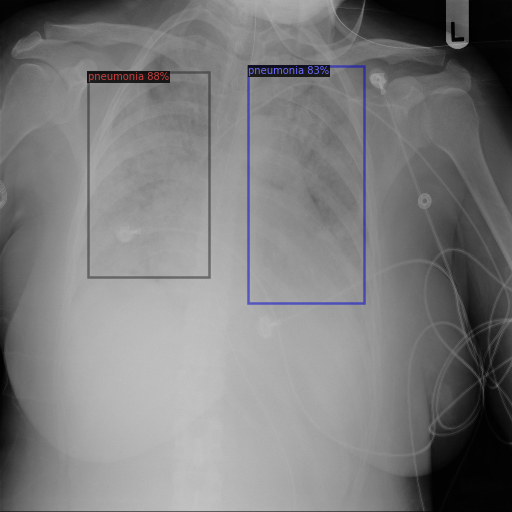


Ground Truth


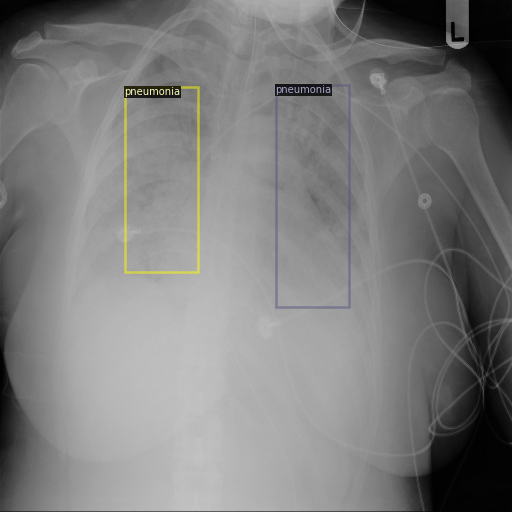

/content/drive/MyDrive/colab/input/train/b9114176-0ece-4eb7-9972-dfdd6b867196.jpg

Prediction


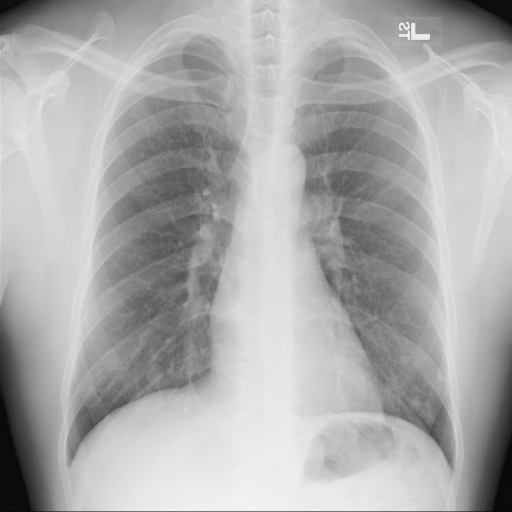


Ground Truth


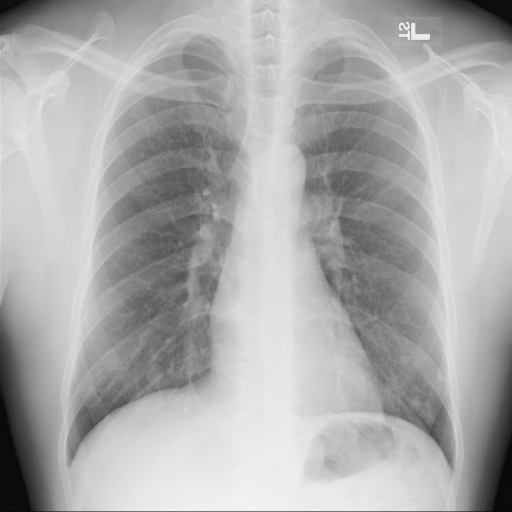

In [36]:
from detectron2.utils.visualizer import ColorMode
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(base_dir + "/output", "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

predictor = DefaultPredictor(cfg)

for d in random.sample(X_val, 2): 
# def predict():     
  im = cv2.imread(d['file_name'])
  print(d['file_name'])
  outputs = predictor(im)  
  v = Visualizer(im[:, :, ::-1],
                  metadata=pnuemonia_metadata, 
                  scale=0.5, 
                  instance_mode=ColorMode.IMAGE_BW   
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu")) 

  print("\nPrediction")
  cv2_imshow(out.get_image()[:, :, ::-1])

  print("\nGround Truth")
  show(d)
    